In [5]:
# 最小可运行项目：基于LSTM的股票走势预测系统
# 步骤：选股 + 技术指标生成 + 滑窗样本构建 + LSTM模型训练 + 预测 + 可视化 + 买入策略判断 + 数据保存

import pandas as pd
import numpy as np
import akshare as ak
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import os

###############################
# 依赖提示（修复 micropip 报错）
###############################
# 若运行中出现 pandas_ta 报错可使用：pip install pandas-ta

try:
    import pandas_ta as ta
except ModuleNotFoundError:
    raise ModuleNotFoundError("pandas_ta 未安装，请运行 pip install pandas-ta")


###############################
# 1. 选股逻辑：获取沪深300中前10只股票（按代码排序）
###############################

stocks = ak.index_stock_cons(symbol="000300")

In [6]:
stocks

,品种代码,品种名称,纳入日期
0,302132,中航成飞,2025-06-16
1,001391,国货航,2025-06-16
2,688047,龙芯中科,2025-06-16
3,002600,领益智造,2025-06-16
4,601077,渝农商行,2025-06-16
...,...,...,...
295,000425,徐工科技,2005-04-08
296,000157,中联重科,2005-04-08
297,000063,中兴通讯,2005-04-08
298,000001,深发展A,2005-04-08


In [7]:
stocks = stocks.sort_values("品种代码").reset_index(drop=True)
selected_codes = list(stocks.loc[:19, '品种代码'])

In [8]:
# os.makedirs("data", exist_ok=True)


###############################
# 2. 获取数据 + 生成技术指标 + 保存CSV
###############################

def fetch_and_process(code, start_date="20100101", end_date="20200101"):
    df = ak.stock_zh_a_hist(symbol=code, period="daily", start_date=start_date, end_date=end_date, adjust="qfq")
    df = df.rename(columns={"日期": "date", "开盘": "open", "收盘": "close", "最高": "high", "最低": "low", "成交量": "volume"})
    df['code'] = code
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    df.ta.sma(length=5, append=True)
    df.ta.rsi(length=14, append=True)
    df.ta.macd(append=True)

    df = df.dropna().reset_index(drop=True)
    # df.to_csv(f"data/{code}_features.csv", index=False, encoding="utf-8-sig")
    return df

stock_dfs_train = [fetch_and_process(code, start_date="20100101", end_date= "20200101") for code in selected_codes]
data_train = pd.concat(stock_dfs_train)

stock_dfs_test = [fetch_and_process(code, start_date="20200101", end_date="20250801") for code in selected_codes]
data_test = pd.concat(stock_dfs_test)

In [9]:
data_train

,date,股票代码,open,close,high,low,volume,成交额,振幅,涨跌幅,涨跌额,换手率,code,SMA_5,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,2010-02-25,000001,4.72,4.90,4.99,4.70,347879,7.708365e+08,6.12,3.38,0.16,1.19,000001,4.840,50.236032,-0.030742,0.008365,-0.039107
1,2010-02-26,000001,4.85,5.00,5.07,4.83,450217,1.008966e+09,4.90,2.04,0.10,1.54,000001,4.840,53.058230,-0.015502,0.018884,-0.034386
2,2010-03-02,000001,5.16,5.24,5.55,5.16,684647,1.599220e+09,7.80,4.80,0.24,2.34,000001,4.912,59.059240,0.015761,0.040117,-0.024356
3,2010-03-03,000001,5.24,5.31,5.33,5.13,284111,6.554447e+08,3.82,1.34,0.07,0.97,000001,5.038,60.639739,0.045659,0.056012,-0.010353
4,2010-03-04,000001,5.32,5.24,5.43,5.20,376321,8.773898e+08,4.33,-1.32,-0.07,1.29,000001,5.138,58.219322,0.062979,0.058666,0.004313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2255,2019-12-25,000617,7.62,7.55,7.64,7.51,11844,1.395485e+07,1.71,-0.79,-0.06,0.41,000617,7.682,49.557271,0.024771,0.036796,-0.012025
2256,2019-12-26,000617,7.58,7.60,7.63,7.50,13401,1.576868e+07,1.72,0.66,0.05,0.47,000617,7.638,52.026889,0.024399,0.029140,-0.004740
2257,2019-12-27,000617,7.58,7.60,7.80,7.58,23050,2.753773e+07,2.89,0.00,0.00,0.80,000617,7.592,52.026889,0.023830,0.022856,0.000974
2258,2019-12-30,000617,7.61,7.80,7.90,7.45,38246,4.592254e+07,5.92,2.63,0.20,1.33,000617,7.632,60.906020,0.039067,0.030475,0.008592


In [10]:
data_test

,date,股票代码,open,close,high,low,volume,成交额,振幅,涨跌幅,涨跌额,换手率,code,SMA_5,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,2020-02-26,000001,12.53,12.75,13.03,12.46,1176599,1.769612e+09,4.45,-0.39,-0.05,0.61,000001,13.046,41.713553,-0.391830,0.161244,-0.553074
1,2020-02-27,000001,12.72,12.87,12.91,12.65,975271,1.464606e+09,2.04,0.94,0.12,0.50,000001,12.950,44.182968,-0.368553,0.147617,-0.516170
2,2020-02-28,000001,12.61,12.26,12.80,12.22,1300644,1.906892e+09,4.51,-4.74,-0.61,0.67,000001,12.734,35.864792,-0.394778,0.097114,-0.491892
3,2020-03-02,000001,12.31,12.55,12.71,12.22,1116581,1.647432e+09,4.00,2.37,0.29,0.58,000001,12.646,41.503220,-0.387691,0.083360,-0.471051
4,2020-03-03,000001,12.72,12.48,12.75,12.39,1153584,1.705816e+09,2.87,-0.56,-0.07,0.59,000001,12.582,40.575932,-0.383305,0.070197,-0.453502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2025-07-28,000617,8.90,9.38,9.66,8.84,4212513,3.911903e+09,9.21,5.39,0.48,3.33,000617,9.120,63.054436,0.474904,-0.037797,0.512701
1316,2025-07-29,000617,9.37,9.77,9.85,9.32,4125767,3.976888e+09,5.65,4.16,0.39,3.26,000617,9.228,66.984910,0.498794,-0.011126,0.509920
1317,2025-07-30,000617,9.88,8.99,9.88,8.88,4486614,4.136392e+09,10.24,-7.98,-0.78,3.55,000617,9.228,54.497464,0.449605,-0.048252,0.497857
1318,2025-07-31,000617,8.97,8.66,9.02,8.60,3017480,2.659568e+09,4.67,-3.67,-0.33,2.39,000617,9.140,50.230960,0.379618,-0.094591,0.474209


In [26]:
###############################
# 3. 构建滑动窗口样本（10天预测1天）
###############################
class StockDataset(Dataset):
    def __init__(self, df, seq_len=10):
        features = ['close', 'SMA_5', 'RSI_14', 'MACD_12_26_9', "open", "high", "low", "振幅", "涨跌幅"]
        df = df.copy()
        scaler = MinMaxScaler()
        df[features] = scaler.fit_transform(df[features])

        self.x, self.y_cls, self.y_reg, self.last_close = [], [], [], []

        for _, stock in df.groupby('code'):
            stock = stock.reset_index(drop=True)
            for i in range(len(stock) - seq_len - 1):
                window = stock.iloc[i:i+seq_len]
                target = stock.iloc[i+seq_len]
                # delta = (target['close'] - stock.iloc[i+seq_len-1]['close']) / stock.iloc[i+seq_len-1]['close']
                delta = (target['close'] - stock.iloc[i+seq_len-1]['close'])

                target_pct = target['涨跌幅']

                # 将涨跌幅分为三类：跌、平、涨
                if target_pct < -0.01:  # 跌幅超0.01%
                    target_cls = 0
                elif target_pct > 0.01:  # 涨幅超0.01%
                    target_cls = 2
                else:  # 平
                    target_cls = 1
                self.x.append(window[features].values)
                self.y_reg.append(delta)
                self.y_cls.append(target_cls)
                self.last_close.append(stock.iloc[i+seq_len-1]['close'])

        self.x = torch.FloatTensor(np.array(self.x))
        self.y_reg = torch.FloatTensor(np.array(self.y_reg))
        self.y_cls = torch.LongTensor(np.array(self.y_cls)).long()  # 分类目标需要是长整数
        self.last_close = torch.FloatTensor(np.array(self.last_close))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y_cls[idx], self.y_reg[idx], self.last_close[idx]

dataset_train = StockDataset(data_train)
dataset_test = StockDataset(data_test)

In [27]:
len(dataset_train), len(dataset_test)

(44015, 26168)

In [28]:
dataset_train[1][0].shape

torch.Size([10, 9])

In [29]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [30]:
###############################
# 4. 构建 LSTM 模型
###############################
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc_cls = nn.Linear(hidden_dim, 3)
        self.fc_reg = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_cls(out), self.fc_reg(out).squeeze()

model = StockLSTM(input_dim=9, hidden_dim=64)
criterion_cls = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1, Loss: 5.3238
Epoch 2, Loss: 0.1600
Epoch 3, Loss: 0.1584
Epoch 4, Loss: 0.1676
Epoch 5, Loss: 0.1590
Epoch 6, Loss: 0.1624
Epoch 7, Loss: 0.1623
Epoch 8, Loss: 0.1583
Epoch 9, Loss: 0.1622
Epoch 10, Loss: 0.1606
Epoch 11, Loss: 0.1617
Epoch 12, Loss: 0.1646
Epoch 13, Loss: 0.1601
Epoch 14, Loss: 0.1646
Epoch 15, Loss: 0.1617
Epoch 16, Loss: 0.1608
Epoch 17, Loss: 0.1609
Epoch 18, Loss: 0.1584
Epoch 19, Loss: 0.1613
Epoch 20, Loss: 0.1597
Epoch 21, Loss: 0.1573
Epoch 22, Loss: 0.1638
Epoch 23, Loss: 0.1605
Epoch 24, Loss: 0.1634
Epoch 25, Loss: 0.1599
Epoch 26, Loss: 0.1610
Epoch 27, Loss: 0.1549
Epoch 28, Loss: 0.1598
Epoch 29, Loss: 0.1650
Epoch 30, Loss: 0.1641
分类准确率: 1.0000
回归RMSE: 0.0075


/home/chen_c6/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/chen_c6/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chen_c6/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chen_c6/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chen_c6/miniconda3/envs/tf/lib/p

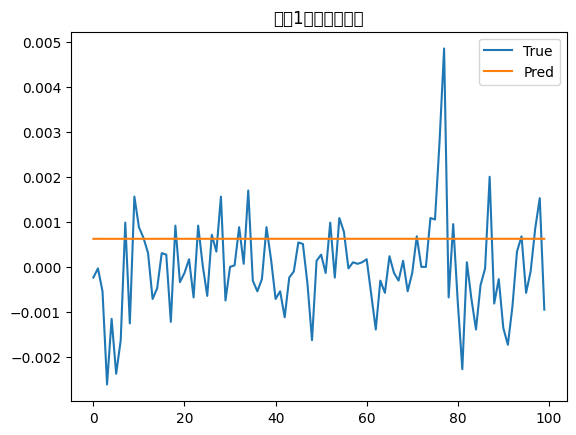


📈 买入建议判断：
样本0: 预测涨幅 0.06%，建议：❌ 观望
样本1: 预测涨幅 0.06%，建议：❌ 观望
样本2: 预测涨幅 0.06%，建议：❌ 观望
样本3: 预测涨幅 0.06%，建议：❌ 观望
样本4: 预测涨幅 0.06%，建议：❌ 观望
样本5: 预测涨幅 0.06%，建议：❌ 观望
样本6: 预测涨幅 0.06%，建议：❌ 观望
样本7: 预测涨幅 0.06%，建议：❌ 观望
样本8: 预测涨幅 0.06%，建议：❌ 观望
样本9: 预测涨幅 0.06%，建议：❌ 观望
样本10: 预测涨幅 0.06%，建议：❌ 观望
样本11: 预测涨幅 0.06%，建议：❌ 观望
样本12: 预测涨幅 0.06%，建议：❌ 观望
样本13: 预测涨幅 0.06%，建议：❌ 观望
样本14: 预测涨幅 0.06%，建议：❌ 观望
样本15: 预测涨幅 0.06%，建议：❌ 观望
样本16: 预测涨幅 0.06%，建议：❌ 观望
样本17: 预测涨幅 0.06%，建议：❌ 观望
样本18: 预测涨幅 0.06%，建议：❌ 观望
样本19: 预测涨幅 0.06%，建议：❌ 观望
样本20: 预测涨幅 0.06%，建议：❌ 观望
样本21: 预测涨幅 0.06%，建议：❌ 观望
样本22: 预测涨幅 0.06%，建议：❌ 观望
样本23: 预测涨幅 0.06%，建议：❌ 观望
样本24: 预测涨幅 0.06%，建议：❌ 观望
样本25: 预测涨幅 0.06%，建议：❌ 观望
样本26: 预测涨幅 0.06%，建议：❌ 观望
样本27: 预测涨幅 0.06%，建议：❌ 观望
样本28: 预测涨幅 0.06%，建议：❌ 观望
样本29: 预测涨幅 0.06%，建议：❌ 观望
样本30: 预测涨幅 0.06%，建议：❌ 观望
样本31: 预测涨幅 0.06%，建议：❌ 观望
样本32: 预测涨幅 0.06%，建议：❌ 观望
样本33: 预测涨幅 0.06%，建议：❌ 观望
样本34: 预测涨幅 0.06%，建议：❌ 观望
样本35: 预测涨幅 0.06%，建议：❌ 观望
样本36: 预测涨幅 0.06%，建议：❌ 观望
样本37: 预测涨幅 0.06%，建议：❌ 观望
样本38: 预测涨幅 0.06%，建议：❌ 观望
样本39: 预测涨幅 0.06%，建议：❌ 观望

In [32]:

###############################
# 5. 训练模型
###############################
model.to(device)
for epoch in range(30):
    model.train()
    total_loss = 0
    for x, y_cls, y_reg, _ in train_loader:
        x, y_cls, y_reg = x.to(device), y_cls.to(device), y_reg.to(device)
        out_cls, out_reg = model(x)
        loss = 0.3 * criterion_cls(out_cls, y_cls) + 0.7 * criterion_reg(out_reg, y_reg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


###############################
# 6. 评估 + 可视化 + 买入建议
###############################
model.eval()
model.to("cpu")
y_true_cls, y_pred_cls = [], []
y_true_reg, y_pred_reg = [], []
last_closes, predicted_deltas = [], []

with torch.no_grad():
    for x, y_cls, y_reg, last_close in test_loader:
        out_cls, out_reg = model(x)
        y_true_cls += y_cls.tolist()
        y_pred_cls += out_cls.argmax(dim=1).tolist()
        y_true_reg += y_reg.tolist()
        y_pred_reg += out_reg.tolist()
        last_closes += last_close
        predicted_deltas += out_reg.tolist()

acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"分类准确率: {acc:.4f}")

rmse = mean_squared_error(y_true_reg, y_pred_reg, squared=False)
print(f"回归RMSE: {rmse:.4f}")

plt.plot(y_true_reg[:100], label="True")
plt.plot(y_pred_reg[:100], label="Pred")
plt.title("未来1日收益率预测")
plt.legend()
plt.show()

print("\n📈 买入建议判断：")
threshold = 0.01
for i in range(len(predicted_deltas)):
    flag = "✅ 买入" if predicted_deltas[i] > threshold else "❌ 观望"
    print(f"样本{i}: 预测涨幅 {predicted_deltas[i]*100:.2f}%，建议：{flag}")
